In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt  # doctest: +SKIP
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.stats import kruskal
from scipy.stats import spearmanr
from scipy.stats import kendalltau

from supervised_sentiment_analysis import *
from constants import *
from utilities import *

In [2]:
merged_results = pickle.load(open('merged_results.P', 'rb'))
merged_results['Valid Vector'] = merged_results['Skip Thought Vector'].apply(lambda x: ~np.isnan(x).any())
removed_results = merged_results[~merged_results['Valid Vector']]
merged_results = merged_results[merged_results['Valid Vector']]
labeled_results = merged_results[merged_results['Categorical Tag'] != 'no tag']
q1_results = merged_results[merged_results['Question'] == Q1]
q1_labeled_results = labeled_results[labeled_results['Question'] == Q1]
q1_features = np.array(q1_labeled_results['Skip Thought Vector'].tolist())
q1_labels = np.array(q1_labeled_results['Categorical Tag'])

In [3]:
unprocessed_results = get_problem_data(DATA)
complete_results = merge_problem_data(unprocessed_results)
cont_results = complete_results[complete_results['Question'] == cont_question]
challenge_results = complete_results[complete_results['Question'] == challenge_question]
prepared_results = complete_results[complete_results['Question'] == prepared_question]

In [4]:
print(f"Total number of students: {complete_results['username'].unique().shape[0]} \n \
      Total number of responses {complete_results.shape[0]}")

Total number of students: 7395 
       Total number of responses 39909


In [5]:
def get_continuity_prediction(row):
    username = row['username']
    problem = row['Problem']
    cont_prediction = cont_results[(cont_results['username'] == username) & (cont_results['Problem'] == problem)]['Answer']
    assert len(cont_prediction) < 2
    if len(cont_prediction) == 0:
        return 'none'
    return cont_prediction.iloc[0]
merged_results['continuity'] = merged_results.apply(get_continuity_prediction, axis = 1)

In [6]:
def get_challenge(row):
    username = row['username']
    problem = row['Problem']
    challenge_prediction = challenge_results[(challenge_results['username'] == username) & (challenge_results['Problem'] == problem)]['Answer']
    assert len(challenge_prediction) < 2
    if len(challenge_prediction) == 0:
        return 'none'
    return challenge_prediction.iloc[0]
merged_results['challenge'] = merged_results.apply(get_challenge, axis = 1)

In [7]:
def get_prepared(row):
    username = row['username']
    problem = row['Problem']
    prediction = prepared_results[(prepared_results['username'] == username) & (prepared_results['Problem'] == problem)]['Answer']
    assert len(prediction) < 2
    if len(prediction) == 0:
        return 'none'
    return prediction.iloc[0]
merged_results['prepared'] = merged_results.apply(get_prepared, axis = 1)

In [8]:
q1_results = merged_results[merged_results['Question'] == Q1]
clf = SVC()
clf.fit(q1_features, q1_labels)
predictions = clf.predict(list(q1_results['Skip Thought Vector']))
q1_results['prediction'] = predictions

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
challenge_responses = ['Not at all challenging', 'Slightly challenging', 
                       'Moderately challenging', 'Very challenging', 
                       'Extremely challenging/']
continuity_responses = ['Not at all', 'Slightly', 'Moderately', 'Very', 'Extremely']
prepared_responses = ['Not at all prepared', 'Slightly prepared', 'Moderately prepared', 'Very prepared', 'Extremely prepared']
problems = ['fex1', 'fex2', 'fex4', 'ps1', 'ps2', 'ps4']

In [10]:
def get_average_sentiment(results):
    y_pred = list(results['prediction'])
    total = max(len(y_pred), 1)
    positive_count = len([prediction for prediction in y_pred if prediction == 'positive'])
    positive_score = positive_count/total
    negative_count = len([prediction for prediction in y_pred if prediction == 'negative'])
    negative_score = negative_count/total
    
    return [positive_score, negative_score, 1-positive_score-negative_score, positive_score-negative_score]

def plot_sentiment_distribution(results, key = 'challenge', labels = challenge_responses):
    sentiment_scores = []
    response_counts = []
    for label in labels:
        label_results = results[results[key] == label]
        sentiment_scores.append(get_average_sentiment(label_results))
        response_counts.append(len(label_results))
    ind = range(len(sentiment_scores))
    fig, ax = plt.subplots(figsize = (8,8))
    positive_scores = np.array([score[0] for score in sentiment_scores])
    negative_scores = np.array([score[1] for score in sentiment_scores])
    neutral_scores = np.array([score[2] for score in sentiment_scores])
    short_labels = [f"{labels[k]}:\n{response_counts[k]}" for k in range(len(labels))]
    if (labels == challenge_responses) or (labels == prepared_responses):
        short_labels = [f"{' '.join(labels[k].split()[:-1])}:\n{response_counts[k]}" for k in range(len(labels))]
    negative_bars = ax.bar(short_labels, negative_scores, label = 'negative')
    neutral_bars = ax.bar(short_labels, neutral_scores, label = 'neutral', bottom = negative_scores)
    positive_bars = ax.bar(short_labels, positive_scores, label = 'negative', bottom = negative_scores + neutral_scores)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title("Proportion of sentiment classifications by student's\nQuestion 5 (preparedness) response", size = 16)
    ax.set_xlabel("Response: Response Count", size = 16)
    plt.legend((negative_bars, neutral_bars, positive_bars), ('Negative', 'Neutral', 'Positive'), prop={'size': 16})
    plt.show()
    return sentiment_scores

def plot_sentiment_scores(results, key = 'challenge', labels = challenge_responses):
    sentiment_scores = []
    response_counts = []
    for label in labels:
        label_results = results[results[key] == label]
        sentiment_scores.append(get_average_sentiment(label_results)[3])
        response_counts.append(len(label_results))
    ind = range(len(sentiment_scores))
    fig, ax = plt.subplots(figsize = (10,10))
    short_labels = [f"{labels[k]}: {response_counts[k]}" for k in range(len(labels))]
    if (labels == challenge_responses) or (labels == prepared_responses):
        short_labels = [f"{' '.join(labels[k].split()[:-1])}: {response_counts[k]}" for k in range(len(labels))]
    sentiment_bars = ax.scatter(short_labels, sentiment_scores, label = 'sentiment')
    ax.set_title(f"Sentiment score by student's {key} response")
    ax.set_xlabel("Response: Response Count")
    plt.show()
    return sentiment_scores
        

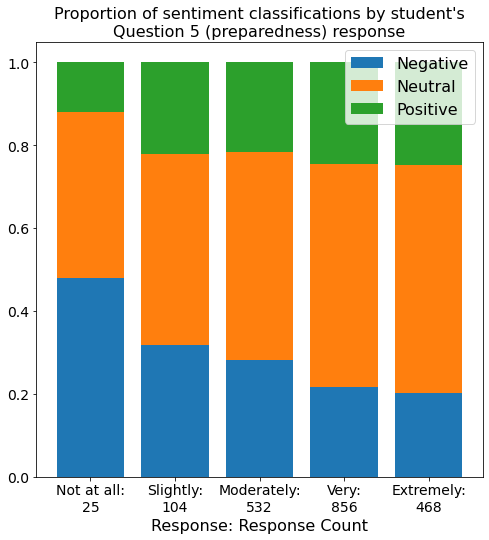

[[0.12, 0.48, 0.4, -0.36],
 [0.22115384615384615,
  0.3173076923076923,
  0.46153846153846156,
  -0.09615384615384615],
 [0.2161654135338346,
  0.2819548872180451,
  0.5018796992481203,
  -0.06578947368421054],
 [0.24532710280373832,
  0.21728971962616822,
  0.5373831775700935,
  0.028037383177570097],
 [0.24786324786324787,
  0.202991452991453,
  0.5491452991452992,
  0.04487179487179488]]

In [11]:
plot_sentiment_distribution(q1_results[q1_results['prepared'] != 'none'], key = 'prepared', labels = prepared_responses)

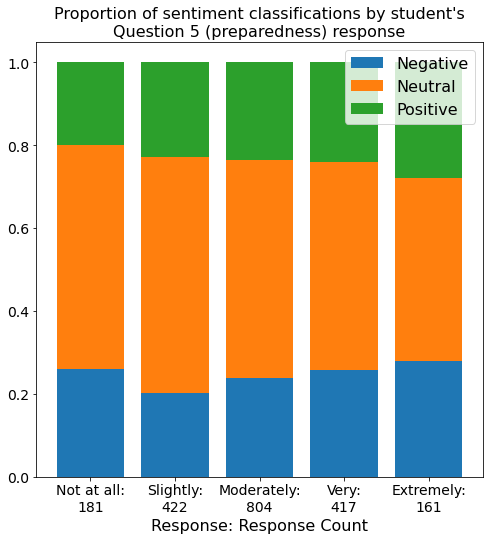

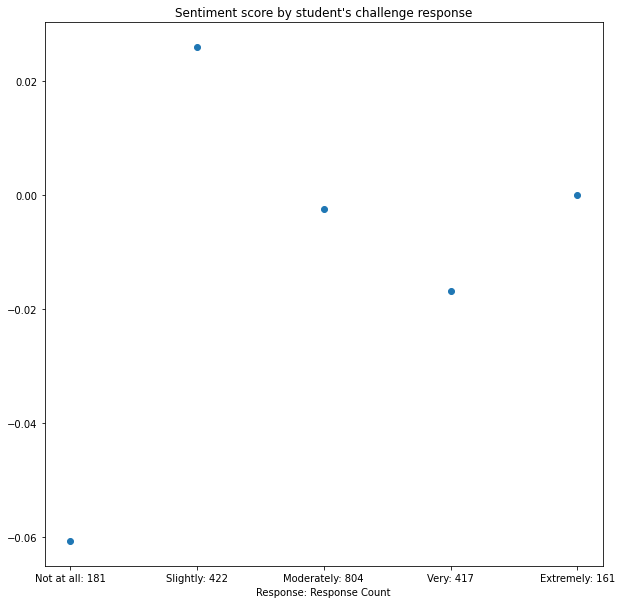

[-0.06077348066298344,
 0.026066350710900466,
 -0.002487562189054715,
 -0.016786570743405282,
 0.0]

In [12]:
plot_sentiment_distribution(q1_results[q1_results['challenge'] != 'none'])
plot_sentiment_scores(q1_results[q1_results['challenge'] != 'none'])

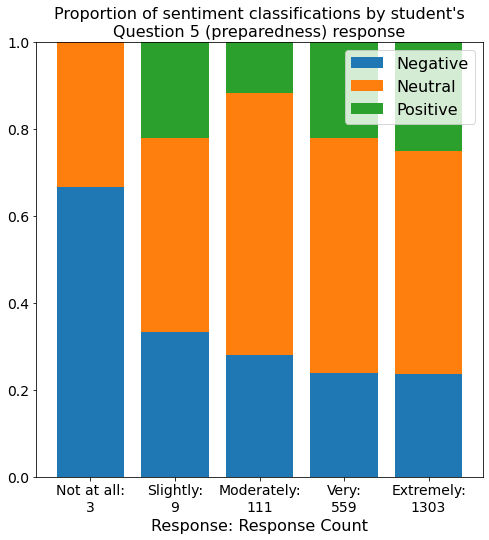

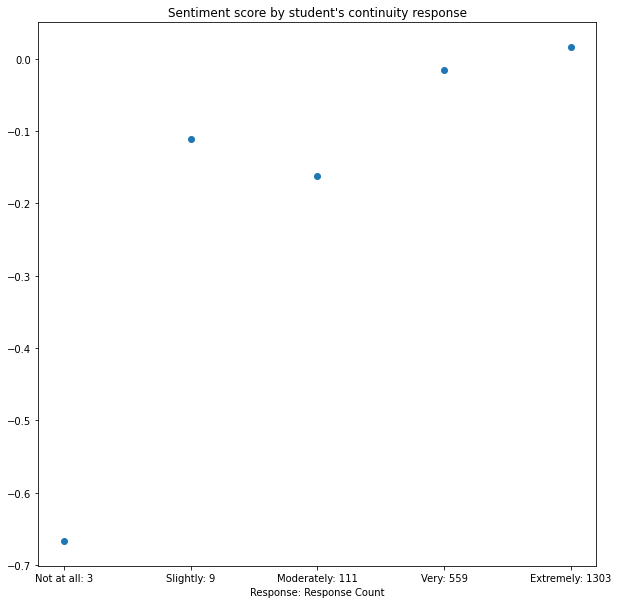

[-0.6666666666666666,
 -0.1111111111111111,
 -0.16216216216216214,
 -0.01610017889087656,
 0.016116653875671544]

In [13]:
plot_sentiment_distribution(q1_results[q1_results['continuity'] != 'none'], key = 'continuity', labels = continuity_responses)
plot_sentiment_scores(q1_results[q1_results['continuity'] != 'none'], key = 'continuity', labels = continuity_responses)

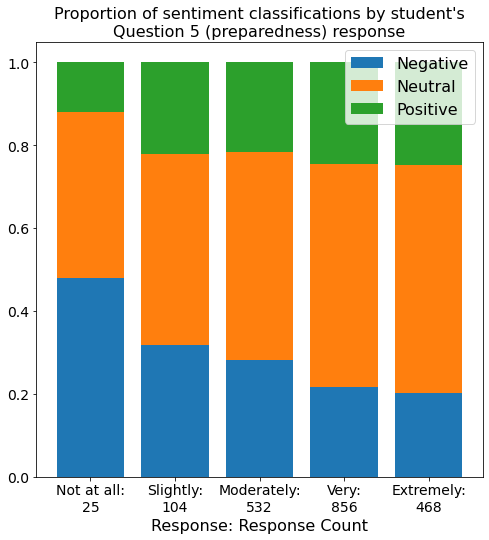

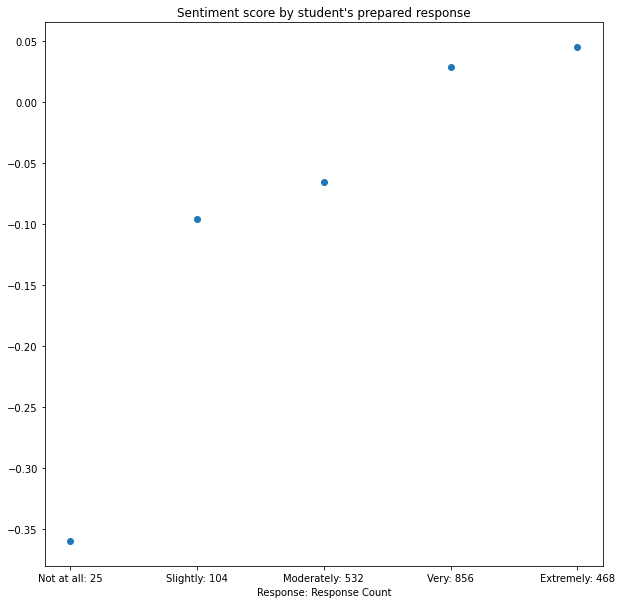

[-0.36,
 -0.09615384615384615,
 -0.06578947368421054,
 0.028037383177570097,
 0.04487179487179488]

In [14]:
plot_sentiment_distribution(q1_results[q1_results['prepared'] != 'none'], key = 'prepared', labels = prepared_responses)
plot_sentiment_scores(q1_results[q1_results['prepared'] != 'none'], key = 'prepared', labels = prepared_responses)

In [15]:
merged_results['Length'] = merged_results['Original'].str.split().str.len()

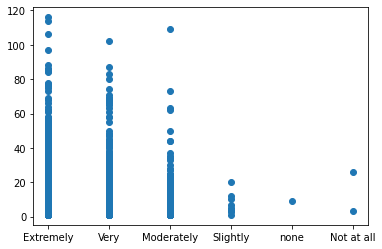

In [16]:
q2_results = merged_results[merged_results['Question'] == Q2]
plt.scatter(list(q2_results['continuity']), list(q2_results['Length']))

In [17]:
question_labels = {
    'challenge': challenge_responses,
    'continuity': continuity_responses,
    'prepared': prepared_responses
}

sentiment_scores = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}



q1_results['score'] = q1_results['prediction'].apply(lambda x: sentiment_scores[x])


/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [18]:
def kruskal_wallis_sentiment(results, key = 'challenge'):
    return kruskal(*[list(results[results[key] == label]['score']) for label in question_labels[key]], nan_policy = 'omit')

def kruskal_wallis_response(results, key = 'challenge'):
    response_scores = {question_labels[key][k]: k for k in range(len(question_labels[key]))}
    results['response score'] = results[key].apply(lambda x: response_scores[x])
    x = [list(results[results['prediction'] == sentiment]['response score']) for sentiment in SENTIMENTS]
    return kruskal(*x, nan_policy = 'omit')

In [19]:

def stat_summary(method):
    print(method.__name__)
    for key, value in question_labels.items():
        print(f"{key}: {method(q1_results, key = key)}")


In [20]:
(kruskal(*[list(q1_results[q1_results['Problem'] == problem]['score']) for problem in problems]),
kruskal(*[list(q1_results[q1_results['Problem'] == problem]['score']) for problem in ['fex1', 'fex2', 'fex4']]),
kruskal(*[list(q1_results[q1_results['Problem'] == problem]['score']) for problem in ['ps1', 'ps2', 'ps4']]))

(KruskalResult(statistic=25.595015994466046, pvalue=0.00010690889952494208),
 KruskalResult(statistic=24.61219271878703, pvalue=4.524079805497485e-06),
 KruskalResult(statistic=0.5713409815482813, pvalue=0.7515102046990327))

In [21]:
stat_summary(kruskal_wallis_sentiment)
stat_summary(kruskal_wallis_response)

kruskal_wallis_sentiment
challenge: KruskalResult(statistic=2.1875991994190995, pvalue=0.7013002310460502)
continuity: KruskalResult(statistic=10.094512963580488, pvalue=0.03886536492920657)
prepared: KruskalResult(statistic=17.039063844788437, pvalue=0.0018994588624442693)
kruskal_wallis_response
challenge: KruskalResult(statistic=7.0083097115271995, pvalue=0.030072177935247107)
continuity: KruskalResult(statistic=7.48328961548865, pvalue=0.023715064312991748)
prepared: KruskalResult(statistic=16.474652722859926, pvalue=0.00026459072457080113)


/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
# this is something I found at the article below, not sure if its relevant to what we're doing
# https://en.wikipedia.org/wiki/Rank_correlation
def spearmanr_sentiment_score(results, key = 'challenge'):
    response_scores = {question_labels[key][k]: k for k in range(len(question_labels[key]))}
    results['response score'] = results[key].apply(lambda x: response_scores[x])
    return spearmanr(list(results['score']), list(results['response score']))

def kendalltau_sentiment_score(results, key = 'challenge'):
    response_scores = {question_labels[key][k]: k for k in range(len(question_labels[key]))}
    results['response score'] = results[key].apply(lambda x: response_scores[x])
    return kendalltau(list(results['score']), list(results['response score']))


In [23]:
stat_summary(spearmanr_sentiment_score)
stat_summary(kendalltau_sentiment_score)

spearmanr_sentiment_score
challenge: SpearmanrResult(correlation=-0.0015554314292122466, pvalue=0.9447858062216041)


/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


continuity: SpearmanrResult(correlation=0.049029853230629174, pvalue=0.028934232333041005)
prepared: SpearmanrResult(correlation=0.07746891267050561, pvalue=0.0005512796052787152)
kendalltau_sentiment_score
challenge: KendalltauResult(correlation=-0.0012732037011543903, pvalue=0.9478437052274034)
continuity: KendalltauResult(correlation=0.04553468020799302, pvalue=0.02868507454491664)
prepared: KendalltauResult(correlation=0.06847653597686827, pvalue=0.0005596535030174012)


In [24]:
def get_sentiment_distribution(results, key = 'challenge'):
    response_counts = []
    for label in question_labels[key]:
        response_count_label = []
        for sentiment in SENTIMENTS:
            response_count_label.append(len(results[(results['prediction'] == sentiment) & (results[key] == label)]))
        response_counts.append(response_count_label)
        
    return pd.DataFrame(response_counts, columns = SENTIMENTS, index = question_labels[key])

get_sentiment_distribution(q1_results, key = 'challenge')

,positive,neutral,negative
Not at all challenging,36,98,47
Slightly challenging,96,241,85
Moderately challenging,190,422,192
Very challenging,100,210,107
Extremely challenging/,45,71,45


array([[0.00642398, 0.00959693, 0.02521008],
       [0.04925054, 0.04606526, 0.06932773],
       [0.24625268, 0.256238  , 0.31512605],
       [0.4496788 , 0.44145873, 0.3907563 ],
       [0.248394  , 0.24664107, 0.19957983]])

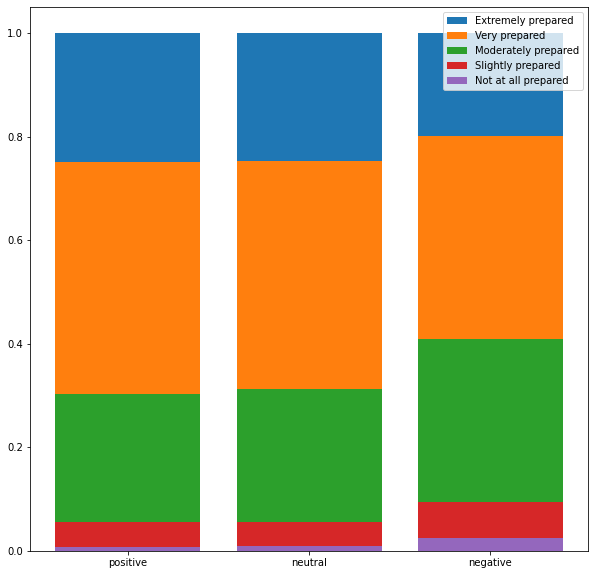

In [25]:
def plot_responses_by_sentiment(results, key = 'challenge', normalize = False):
    width = 0.35
    sentiment_distribution = get_sentiment_distribution(results, key = key)
    arr = np.array(sentiment_distribution)
    if normalize:
        arr = arr/np.sum(arr, axis = 0)
    fig, ax = plt.subplots(figsize = (10, 10))
    bars = []
    for k in range(arr.shape[0]):
        bars.append(ax.bar(SENTIMENTS, np.sum(arr[:arr.shape[0]-k], axis = 0)))
    plt.legend(bars, sentiment_distribution.index[::-1])
    return arr
plot_responses_by_sentiment(q1_results, key = 'prepared', normalize = True)

In [26]:
from scipy.stats._stats import _kendall_dis
def SomersD(x, y):

    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.size != y.size:
        raise ValueError("All inputs must be of the same size, "
                         "found x-size %s and y-size %s" % (x.size, y.size))

    def count_rank_tie(ranks):
        cnt = np.bincount(ranks).astype('int64', copy=False)
        cnt = cnt[cnt > 1]
        return ((cnt * (cnt - 1) // 2).sum(),
            (cnt * (cnt - 1.) * (cnt - 2)).sum(),
            (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

    size = x.size
    perm = np.argsort(y)  # sort on y and convert y to dense ranks
    x, y = x[perm], y[perm]
    y = np.r_[True, y[1:] != y[:-1]].cumsum(dtype=np.intp)

    # stable sort on x and convert x to dense ranks
    perm = np.argsort(x, kind='mergesort')
    x, y = x[perm], y[perm]
    x = np.r_[True, x[1:] != x[:-1]].cumsum(dtype=np.intp)

    dis = _kendall_dis(x, y)  # discordant pairs

    obs = np.r_[True, (x[1:] != x[:-1]) | (y[1:] != y[:-1]), True]
    cnt = np.diff(np.where(obs)[0]).astype('int64', copy=False)

    ntie = (cnt * (cnt - 1) // 2).sum()  # joint ties
    xtie, x0, x1 = count_rank_tie(x)     # ties in x, stats
    ytie, y0, y1 = count_rank_tie(y)     # ties in y, stats

    tot = (size * (size - 1)) // 2

    # Note that tot = con + dis + (xtie - ntie) + (ytie - ntie) + ntie
    #               = con + dis + xtie + ytie - ntie
    #con_minus_dis = tot - xtie - ytie + ntie - 2 * dis
    SD = (tot - xtie - ytie + ntie - 2 * dis) / (tot - ntie)
    return (SD, dis)

In [27]:
def somersd_sentiment_score(results, key = 'challenge'):
    response_scores = {question_labels[key][k]: k for k in range(len(question_labels[key]))}
    results['response score'] = results[key].apply(lambda x: response_scores[x])
    return SomersD(list(results['score']), list(results['response score']))

stat_summary(somersd_sentiment_score)

somersd_sentiment_score
challenge: (-0.000951542229931844, 442350)
continuity: (0.030953316092422918, 266798)
prepared: (0.05056909579416905, 369778)


/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
questions = list(complete_results['Question'].unique())